<a href="https://colab.research.google.com/github/skj092/ASR_Experiment/blob/main/Copy_of_sew_wavlm_w_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install transformers
! pip install jiwer
! pip install --upgrade librosa
! pip install datasets
! pip install --upgrade wandb
! pip install noisereduce

In [4]:
import os
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from google.colab import userdata
from datetime import datetime
import wandb
from wandb.keras import WandbCallback
from datasets import load_dataset


import librosa

import warnings
warnings.simplefilter('ignore')

In [37]:
dataset = load_dataset("google/fleurs", "en_us", split="train[:100]")

In [38]:
dataset

Dataset({
    features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
    num_rows: 100
})

# EDA and Data Preprocessing

In [39]:
idx = np.random.randint(0, len(dataset))
idx = 0
import IPython.display as ipd
audio, sr = librosa.load(os.path.join('/'.join(dataset['path'][idx].split('/')[:-1]), dataset['audio'][idx]['path']), sr=32000)
print(dataset['transcription'][idx])
ipd.display(ipd.Audio(audio, rate=sr))

a tornado is a spinning column of very low-pressure air which sucks the surrounding air inward and upward


a tornado is a spinning column of very low-pressure air which sucks the surrounding air inward and upward


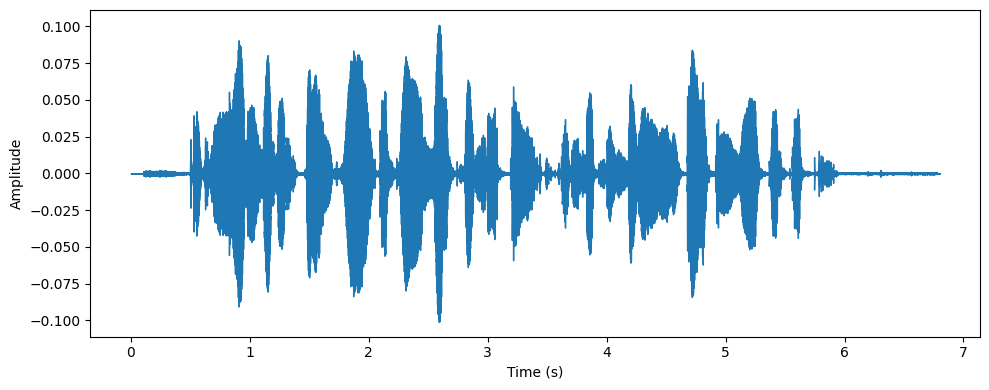

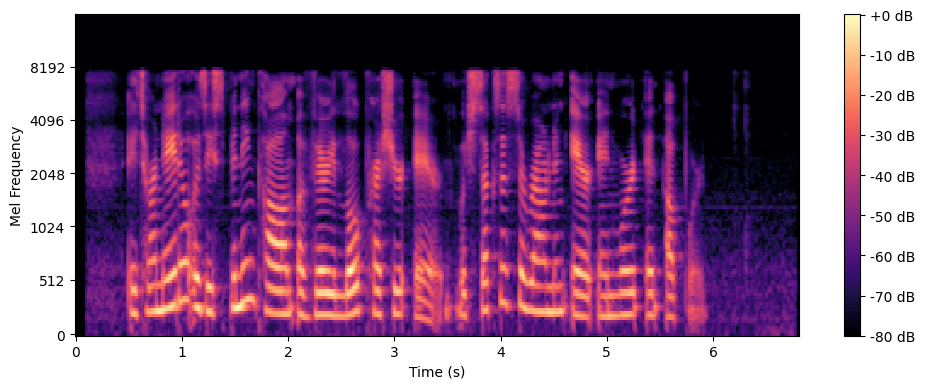

In [40]:
import matplotlib.pyplot as plt


# Load the audio file using librosa
idx = np.random.randint(0, len(dataset))
idx = 0
audio, sr = librosa.load(os.path.join('/'.join(dataset['path'][idx].split('/')[:-1]), dataset['audio'][idx]['path']), sr=32000)

print(dataset['transcription'][idx])
ipd.display(ipd.Audio(audio, rate=sr))

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
# plt.title(f"Waveform - Audio File ID: {row['id']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Plot the log Mel spectrogram
plt.figure(figsize=(10, 4))
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
# plt.title(f"Log Mel Spectrogram - Audio File ID: {row['id']}")
plt.xlabel("Time (s)")
plt.ylabel("Mel Frequency")
plt.tight_layout()
plt.show()

**Preprocessing**

In [41]:
import noisereduce as nr


def apply_preemphasis(audio, pre_emphasis=0.97):
    return np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

def frame_signal(audio, sr, frame_size=0.025, frame_stride=0.01):
    frame_length = int(sr * frame_size)
    frame_step = int(sr * frame_stride)
    signal_length = len(audio)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(audio, z)

    indices = np.arange(0, frame_length).reshape(1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
    frames = pad_signal[indices]
    return frames

def apply_windowing(frames):
    hamming = np.hamming(frames.shape[1])
    windowed_frames = frames * hamming
    return windowed_frames

def remove_noise(audio, sr):
    return nr.reduce_noise(y=audio, sr=sr)

In [42]:
%%time
paths = [os.path.join('/'.join(dataset['path'][idx].split('/')[:-1]), dataset['audio'][idx]['path']) for idx in range(len(dataset))]

CPU times: user 13 s, sys: 25.3 ms, total: 13.1 s
Wall time: 15 s


In [43]:
%%time
train_ratio = 0.8  # Change this to your desired train-validation split ratio
total_samples = len(dataset)

train_split_size = int(total_samples * train_ratio)
valid_split_size = total_samples - train_split_size

df = pd.DataFrame({
    'path': paths,
    'sentence': dataset['transcription'],
    'split': ['train'] * train_split_size + ['valid'] * valid_split_size
})
df.head()

CPU times: user 2.06 ms, sys: 1.03 ms, total: 3.08 ms
Wall time: 16.3 ms


,path,sentence,split
0,/root/.cache/huggingface/datasets/downloads/ex...,a tornado is a spinning column of very low-pre...,train
1,/root/.cache/huggingface/datasets/downloads/ex...,former u.s. speaker of the house newt gingrich...,train
2,/root/.cache/huggingface/datasets/downloads/ex...,the island was first inhabited by the taínos a...,train
3,/root/.cache/huggingface/datasets/downloads/ex...,these nerve impulses can be sent so quickly th...,train
4,/root/.cache/huggingface/datasets/downloads/ex...,on september 24 1759 arthur guinness signed a ...,train


In [44]:
print(df.iloc[0]['path'])
print(df.iloc[1]['path'])

/root/.cache/huggingface/datasets/downloads/extracted/ee72a6213f7cabb647adadc74f3888674aa278435dca4f54892382eda44c8014/train/10004088536354799741.wav
/root/.cache/huggingface/datasets/downloads/extracted/ee72a6213f7cabb647adadc74f3888674aa278435dca4f54892382eda44c8014/train/10012216926115652402.wav


In [45]:
Config = {
    'model_name': 'facebook/wav2vec2-base',
    'lr': 3e-4,
    'wd': 1e-5,
    'T_0': 10,
    'T_mult': 2,
    'eta_min': 1e-6,
    'nb_epochs': 5,
    'train_bs': 16,
    'valid_bs': 16,
    'sampling_rate': 16000,
}

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is', device)

# Setup user secrets for login
wandb_api = userdata.get("wandb-key")

# Login
wandb.login(key = wandb_api)

run = wandb.init(project = "ASR-exp1",
                 name = f"Run_{datetime.now().strftime('%d%m%Y%H%M%S')}",
                 notes = "full_dataset",
                 tags = [],
                 config = dict(competition = 'asr2',
                               _wandb_kernel = 'skj092',
                               batch_size = Config['train_bs'],
                               epochs = Config['nb_epochs'],
                               learning_rate = 0.005)
)

device is cuda


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: skj092. Use `wandb login --relogin` to force relogin


In [50]:
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    Wav2Vec2CTCTokenizer,
    Wav2Vec2FeatureExtractor
)

In [51]:
def read_audio(mp3_path, target_sr=16000):
    audio, sr = librosa.load(mp3_path, sr=32000)
    audio_array = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    return audio

def read_audio_and_preprocess(mp3_path, target_sr=16000):
    audio, sr = librosa.load(mp3_path, sr=32000)
    audio = remove_noise(audio, sr=sr)
    return audio

def wandb_log(**kwargs):
    for k, v in kwargs.items():
        wandb.log({k: v})

def construct_vocab(texts):
    all_text = " ".join(texts)
    vocab = list(set(all_text))
    return vocab

def save_vocab(dataframe):
    vocab = construct_vocab(dataframe['sentence'].tolist())
    vocab_dict = {v: k for k, v in enumerate(vocab)}
    vocab_dict["__"] = vocab_dict[" "]
    _ = vocab_dict.pop(" ")
    vocab_dict["[UNK]"] = len(vocab_dict)
    vocab_dict["[PAD]"] = len(vocab_dict)

    with open('vocab.json', 'w') as fl:
        json.dump(vocab_dict, fl)

    print("Created Vocab file!")

In [52]:

class ASRDataset(Dataset):
    def __init__(self, df, config, is_test=False):
        self.df = df
        self.config = config
        self.is_test = is_test

    def __getitem__(self, idx):
        # First read and pre-process the audio file
        audio = read_audio(self.df.loc[idx]['path'])
        audio = processor(
            audio,
            sampling_rate=self.config['sampling_rate']
        ).input_values[0]

        if self.is_test:
            return {'audio': audio, 'label': -1}
        else:
            # If we are training/validating, also process the labels (actual sentences)
            with processor.as_target_processor():
                labels = processor(self.df.loc[idx]['sentence']).input_ids
            return {'audio': audio, 'label': labels}

    def __len__(self):
        return len(self.df)

def ctc_data_collator(batch):
    input_features = [{"input_values": sample["audio"]} for sample in batch]
    label_features = [{"input_ids": sample["label"]} for sample in batch]
    batch = processor.pad(
        input_features,
        padding=True,
        return_tensors="pt",
    )
    with processor.as_target_processor():
        labels_batch = processor.pad(
            label_features,
            padding=True,
            return_tensors="pt",
        )

    labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
    batch["labels"] = labels
    return batch

In [53]:
def train_one_epoch(model, train_loader, optimizer, device='cuda:0'):
    model.train()
    pbar = tqdm(train_loader, total=len(train_loader))
    avg_loss = 0
    for data in pbar:
        data = {k: v.to(device) for k, v in data.items()}
        loss = model(**data).loss
        loss_itm = loss.item()

        avg_loss += loss_itm
        pbar.set_description(f"loss: {loss_itm:.4f}")
        wandb_log(train_step_loss=loss_itm)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return avg_loss / len(train_loader)

@torch.no_grad()
def valid_one_epoch(model, valid_loader, device='cuda:0'):
    pbar = tqdm(valid_loader, total=len(valid_loader))
    avg_loss = 0
    for data in pbar:
        data = {k: v.to(device) for k, v in data.items()}
        loss = model(**data).loss
        loss_itm = loss.item()

        avg_loss += loss_itm
        pbar.set_description(f"val_loss: {loss_itm:.4f}")
        wandb_log(valid_step_loss=loss_itm)

    return avg_loss / len(valid_loader)

In [55]:
from transformers import SEWForCTC
from transformers import SEWForCTC
train_ratio = 0.8  # Change this to your desired train-validation split ratio
total_samples = len(dataset)

train_split_size = int(total_samples * train_ratio)
valid_split_size = total_samples - train_split_size

df = pd.DataFrame({
    'path': paths,
    'sentence': dataset['transcription'],
    'split': ['train'] * train_split_size + ['valid'] * valid_split_size
})


# Get a paths feature for reading in during dataloading
# train_df = df[df['split'] == 'train'].sample(frac=.01).reset_index(drop=True)
# valid_df = df[df['split'] == 'valid'].sample(frac=.01).reset_index(drop=True)

train_df = df[df['split'] == 'train'].reset_index(drop=True)
valid_df = df[df['split'] == 'valid'].reset_index(drop=True)
print(f"Training on samples: {len(train_df)}, Validation on samples: {len(valid_df)}")
# Construct and save the vocab file
save_vocab(df)

# Init the tokenizer, feature_extractor, processor and model
tokenizer = Wav2Vec2CTCTokenizer(
    "./vocab.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    word_delimiter_token="__"
)
feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=Config['sampling_rate'],
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=False
)
processor = Wav2Vec2Processor(
    feature_extractor=feature_extractor,
    tokenizer=tokenizer
)

model = SEWForCTC.from_pretrained("asapp/sew-tiny-100k-ft-ls100h",
    ctc_loss_reduction="mean",
    ignore_mismatched_sizes=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size = len(tokenizer),
)
wandb.watch(model)

# Freeze the feature encoder part since we won't be training it
model.to(device)
model.freeze_feature_encoder()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=Config['lr'],
    weight_decay=Config['wd']
)

# Construct training and validation dataloaders
train_ds = ASRDataset(train_df, Config)
valid_ds = ASRDataset(valid_df, Config)

train_loader = DataLoader(
    train_ds,
    batch_size=Config['train_bs'],
    collate_fn=ctc_data_collator,
)
valid_loader = DataLoader(
    valid_ds,
    batch_size=Config['valid_bs'],
    collate_fn=ctc_data_collator,
)

Training on samples: 80, Validation on samples: 20
Created Vocab file!


config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/163M [00:00<?, ?B/s]

Some weights of SEWForCTC were not initialized from the model checkpoint at asapp/sew-tiny-100k-ft-ls100h and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([51]) in the model instantiated
- lm_head.weight: found shape torch.Size([32, 512]) in the checkpoint and torch.Size([51, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
# Train the model
best_loss = float('inf')
for epoch in range(Config['nb_epochs']):
    print(f"{'='*40} Epoch: {epoch+1} / {Config['nb_epochs']} {'='*40}")
    train_loss = train_one_epoch(model, train_loader, optimizer, device=device)
    valid_loss = valid_one_epoch(model, valid_loader, device=device)
    wandb_log(train_loss=train_loss, val_loss=valid_loss)
    print(f"train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}")

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), f"ASR1.pt")
        print(f"Saved the best model so far with val_loss: {valid_loss:.4f}")

======================================== Epoch: 1 / 5 ========================================


  0%|          | 0/5 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
p = train_df.iloc[2]['path']
input_values = read_audio(p)
input_values = processor(audio,sampling_rate=Config['sampling_rate']).input_values[0]

# Convert to PyTorch tensor and add batch dimension
input_values = torch.tensor(input_values).unsqueeze(0)
input_values = input_values.to(device)

# Forward pass in the model
with torch.no_grad():
    logits = model(input_values).logits

# Decode the predicted ids to a transcription
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)
transcription[0]

In [ ]:
logits.shape